04_ResNet18_TransferLearning_03dataset.ipynb

# Transfer Learning with Resnet18 using the Wildfire Dataset

In this notebook I'll perform Transfer Learning on ResNet18 using the [Wildfire Dataset](https://doi.org/10.3390/f14091697). 

Note this will be a **binary** classification, with images sized 128x128.

# Import Libraries

In [1]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [2]:
# installed new module to show model summary
from torchinfo import summary

## Import Custom Modules

In [3]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages']

In [4]:
sys.path.append('..')

In [5]:
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

# Define Hyperparameters

Here we're using the same hyperparameters as the publication minus the image size (in the paper they use 128 x 128 images)

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
N_EPOCHS = 50
N_CLASSES = 2

# to be used for height and width of final image
IMAGE_SIZE = 128

In [7]:
# Set manual seed for repeatability
RANDOM_SEED = 42
gen = torch.manual_seed(RANDOM_SEED)

# Prepare Data

## Define Custom Class and Paths

In [8]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [9]:
path_03_dataset = '../data_preprocessing/03_the_wildfire_dataset_250x250/'

annot_file_test = 'labels_03_test_dataset.csv'
annot_file_val = 'labels_03_val_dataset.csv'
annot_file_train = 'labels_03_train_dataset.csv'

In [10]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

## Load Dataset and obtain Statistics

First define the transformations to get statistics

In [11]:
# Convert uint8 to float and divide by 255. 
# This is the equivalent of ToTensor() when used on a PIL image

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE))
                                 ])

In [12]:
train_dataset = CustomFireImagesDataset(annot_file_train, path_03_dataset,
                                         transform = curr_transf)

Calculate statistical properties

In [13]:
from src.data.dataset_properties import dataset_stat_prop

In [15]:
mean_train,std_train = dataset_stat_prop(train_dataset)

In [16]:
print('Statistics of Train Dataset')
print('Mean\t',mean_train)
print('STD\t',std_train)

Statistics of Train Dataset
Mean	 tensor([0.4158, 0.4036, 0.3758])
STD	 tensor([0.2733, 0.2565, 0.2799])


We'll use these values later on to normalize the inputs for training

## Define Train, Validation, and Test Data

In [17]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean_train,std_train)
                                 ])

In [18]:
# Define image classes
img_classes = ('non-fire','fire')

In [19]:
train_dataset = CustomFireImagesDataset(annot_file_train, path_03_dataset,
                                         transform = curr_transf)

val_dataset = CustomFireImagesDataset(annot_file_val, path_03_dataset,
                                         transform = curr_transf)

test_dataset = CustomFireImagesDataset(annot_file_test, path_03_dataset,
                                         transform = curr_transf)

Just a quick check

In [20]:
print('Train Dataset\t',len(train_dataset))
print('Validation Dataset\t',len(val_dataset))
print('Test Dataset\t',len(test_dataset))

Train Dataset	 1887
Validation Dataset	 402
Test Dataset	 410


In [22]:
# Next, create the DataLoaders
# Note that we're only shuffling the train dataloader

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = 2)

val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                            shuffle = False, num_workers = 2)

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, num_workers = 2)

## Plot Images from Sample Batch

In [23]:
from src.visualization.plot_images import display_image_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


non-fire  fire non-fire non-fire  fire non-fire  fire  fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire  fire non-fire  fire  fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire non-fire  fire non-fire non-fire  fire non-fire  fire non-fire non-fire non-fire non-fire  fire non-fire non-fire non-fire  fire non-fire non-fire non-fire  fire non-fire non-fire non-fire non-fire  fire non-fire non-fire non-fire  fire  fire  fire non-fire non-fire


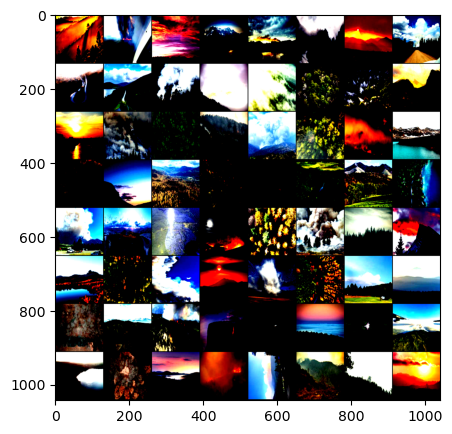

In [24]:
display_image_batch(train_dataloader,1,img_classes)

Note in a future implementation we need to adjust the figure size, as well as the labelling.

# Prepare Model (Resnet18)

In [25]:
from src.models.model_transfer_learning import resnet18_transfer_learning

In [26]:
resnet18 = resnet18_transfer_learning(N_CLASSES)

## Model Summary

In [27]:
summary(resnet18,(BATCH_SIZE,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 64, 64, 64]          (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 64, 64]          (128)
├─ReLU: 1-3                              [64, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [64, 64, 32, 32]          --
├─Sequential: 1-5                        [64, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 32]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 32, 32]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [64, 64, 32, 32]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 32, 32]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 32, 32]  

# Define Optimizer and Loss Function

We'll use Adam optimizer.

In [28]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 0.001)

For loss function we'll use the Cross Entropy loss

In [29]:
loss_function = nn.CrossEntropyLoss()

# Import Training and Validation Loop

In [75]:
from src.models.train_models import train_and_validate

# Helper function for Losses and Accuracy

In [31]:
from src.visualization.plot_model_eval import plot_loss_acc

# Train the Model

We now get to the training phase. We have defined already a number of hyperparameters, but we'll try with a shorter number of epochs.

In [32]:
resnet18_trained, history = train_and_validate(resnet18,loss_function,optimizer,
                                    20,train_dataloader,val_dataloader)

13:33:10	Epoch: 1/20	Train loss: 0.6333	Val. loss: 0.5420	Train acc.: 67.74	Val. acc.: 72.59
13:34:06	Epoch: 2/20	Train loss: 0.4687	Val. loss: 0.5275	Train acc.: 79.20	Val. acc.: 78.97
13:35:02	Epoch: 3/20	Train loss: 0.4126	Val. loss: 0.4958	Train acc.: 81.80	Val. acc.: 78.65
13:35:58	Epoch: 4/20	Train loss: 0.3925	Val. loss: 0.4947	Train acc.: 82.32	Val. acc.: 78.75
13:36:55	Epoch: 5/20	Train loss: 0.3708	Val. loss: 0.4934	Train acc.: 83.63	Val. acc.: 78.84
13:37:51	Epoch: 6/20	Train loss: 0.3552	Val. loss: 0.4807	Train acc.: 85.61	Val. acc.: 77.41
13:38:47	Epoch: 7/20	Train loss: 0.3365	Val. loss: 0.4752	Train acc.: 85.82	Val. acc.: 79.96
13:39:42	Epoch: 8/20	Train loss: 0.3279	Val. loss: 0.4820	Train acc.: 86.34	Val. acc.: 79.29
13:40:41	Epoch: 9/20	Train loss: 0.3229	Val. loss: 0.4976	Train acc.: 86.29	Val. acc.: 78.94
13:41:38	Epoch: 10/20	Train loss: 0.3123	Val. loss: 0.4921	Train acc.: 86.86	Val. acc.: 78.94
13:42:33	Epoch: 11/20	Train loss: 0.3124	Val. loss: 0.4810	Train acc.

## Plot Model Losses and Accuracy

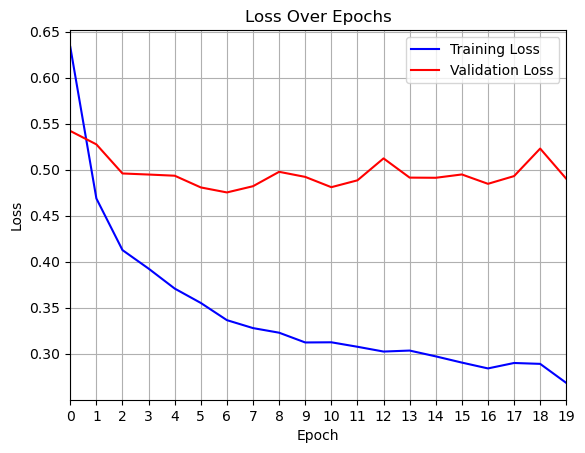

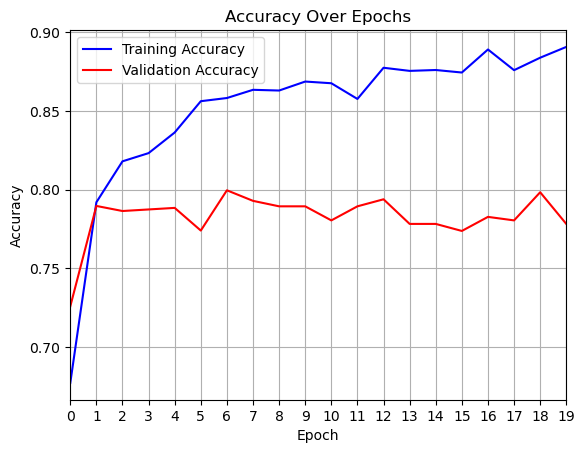

In [33]:
plot_loss_acc(history)

From the graphs, we can see that the training and validation losses do not overlap like in the previous dataset, therefore the model is not generalizing as well as before.

## Train with different set of hyperparameters

We'll retrain with a smaller batch size

In [61]:
resnet18_v2 = resnet18_transfer_learning(N_CLASSES)

In [62]:
optimizer = torch.optim.Adam(resnet18_v2.parameters(), lr = 0.001)

In [63]:
loss_function = nn.CrossEntropyLoss()

In [64]:
train_dataloader_v2 = DataLoader(train_dataset, batch_size = 32,
                              shuffle = True, num_workers = 2)

In [65]:
resnet18_v2_trained, history_v2 = train_and_validate(resnet18_v2,loss_function,optimizer,
                                    20,train_dataloader,val_dataloader)

15:29:52	Epoch: 1/20	Train loss: 0.5978	Val. loss: 0.5300	Train acc.: 68.99	Val. acc.: 77.73
15:30:52	Epoch: 2/20	Train loss: 0.4449	Val. loss: 0.5072	Train acc.: 80.61	Val. acc.: 79.51
15:31:53	Epoch: 3/20	Train loss: 0.4092	Val. loss: 0.4854	Train acc.: 82.34	Val. acc.: 79.64
15:32:57	Epoch: 4/20	Train loss: 0.3774	Val. loss: 0.4861	Train acc.: 83.67	Val. acc.: 80.53
15:33:55	Epoch: 5/20	Train loss: 0.3556	Val. loss: 0.4957	Train acc.: 84.84	Val. acc.: 79.51
15:34:54	Epoch: 6/20	Train loss: 0.3412	Val. loss: 0.4753	Train acc.: 86.25	Val. acc.: 81.42
15:35:51	Epoch: 7/20	Train loss: 0.3364	Val. loss: 0.4825	Train acc.: 86.54	Val. acc.: 81.08
15:36:51	Epoch: 8/20	Train loss: 0.3401	Val. loss: 0.4803	Train acc.: 85.39	Val. acc.: 81.08
15:37:50	Epoch: 9/20	Train loss: 0.3344	Val. loss: 0.4958	Train acc.: 86.60	Val. acc.: 78.97
15:38:50	Epoch: 10/20	Train loss: 0.3211	Val. loss: 0.4901	Train acc.: 86.70	Val. acc.: 79.17
15:39:48	Epoch: 11/20	Train loss: 0.3111	Val. loss: 0.4723	Train acc.

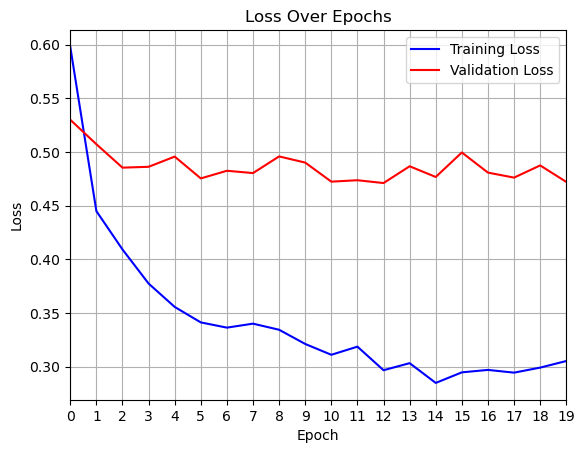

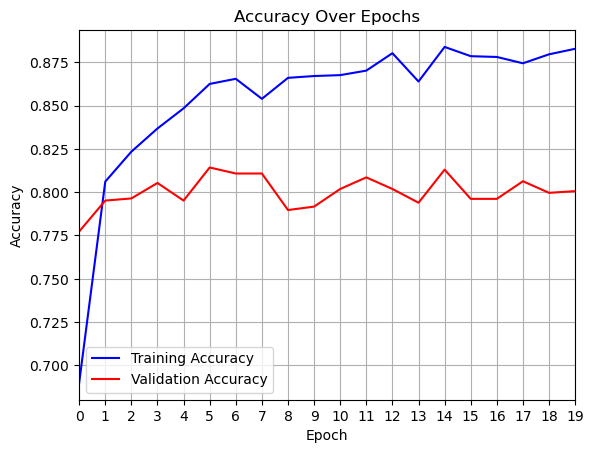

In [66]:
plot_loss_acc(history_v2)

There were no significant improvement, compared with the batch size of 64, therefore we won't proceed any further.

## Save Model

In [67]:
# save the state model of the trained model
torch.save(resnet18_trained.state_dict(), "resnet18_03dataset_trained.pt")

# Evaluate Model

In [68]:
from src.models.model_inference import make_hard_predictions

In [70]:
label_list, pred_list = make_hard_predictions(resnet18_trained,test_dataloader)

In [78]:
from src.visualization.plot_model_eval import calculate_conf_matrix
from src.visualization.plot_model_eval import plot_roc_curve

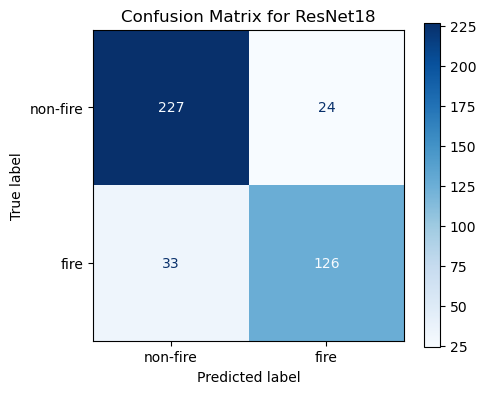

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       251
           1       0.84      0.79      0.82       159

    accuracy                           0.86       410
   macro avg       0.86      0.85      0.85       410
weighted avg       0.86      0.86      0.86       410



In [79]:
report = calculate_conf_matrix(label_list,pred_list,'ResNet18',img_classes,savefig = True)

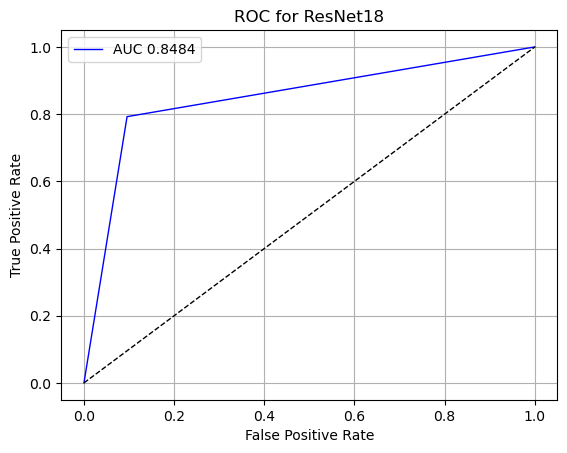

In [77]:
score = plot_roc_curve(label_list,pred_list,'ResNet18')

In [81]:
from sklearn.metrics import classification_report

In [84]:
print(classification_report(label_list,pred_list,digits = 4))

              precision    recall  f1-score   support

           0     0.8731    0.9044    0.8885       251
           1     0.8400    0.7925    0.8155       159

    accuracy                         0.8610       410
   macro avg     0.8565    0.8484    0.8520       410
weighted avg     0.8602    0.8610    0.8602       410



We see that the results of the classification report match very well with what has been reported in the literature for the [Wildfire Dataset](https://doi.org/10.3390/f14091697)

|metric|MobileNetV3|ResNet18|
|:---:|:---:|:---:|
|accuracy| 0.8405| 0.8610|
|precision| 0.8322| 0.8400|
|recall| 0.7799 | 0.7925|
|F1 score| 0.8049| 0.8155|
|AUC score| 0.8397| 0.8484|

Note that there is a a class imbalance in the datset, and this is only the baseline training.

# Conclusion

We've successfully performed transfer learning on ResNet 18 using the Wildfire Dataset.

Note there are still many False Negatives (33), so for the use case of this problem, it may be problematic.

There are other training strategies that we may explore in another notebook.